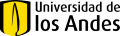

***
# **Competencia: Modelos Avanzados PLN**

## **Descripción del problema:**

...
## **Objetivo:**

...

***
## Integrantes Equipo 20
- Andrés Felipe Ñungo Fernández
- Andrés Julián Gonzalez Barrera
- Hernando Jose Jimenez Díaz
- Gloria Inés López Urbano

***
# Índice

El *notebook* aborda la competencia con la siguiente estructura:

| 🔹 | Sección        |
|----|----------------|
| 1️.   | **Instalación e importe de librerías** |
...
| 2️.   | **Carga de datos y construcción prompt**  |
...
| 3️. | **Desarrollo del modelo** |
...
| 4️. | **Etapa Entrenamiento**   |
...
| 5️. | **Cargue de los datos de validación**  |

***
# 1. Instalación e importe de librerías

In [1]:
import os
import json
import math
import random
from typing import Any, Dict
import time

# Datos
from transformers import logging as hf_logging
from datasets import Dataset

# Modelo
import torch
from torch.utils.data import DataLoader, Dataset as TorchDataset
from torch.optim import AdamW
from torch.nn.utils.rnn import pad_sequence
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    get_scheduler
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

# Herramientas de visualización
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

# Importar archivos .py personalizados
import shared_functions as custom_sharfun  #el archivo .py con funciones compartidas

# Warnings
import warnings
from importlib.metadata import version
hf_logging.set_verbosity_warning()

***
## 1.2 Verificar versionamiento librerías

In [2]:
# Ignorar las warnings
warnings.filterwarnings("ignore") 

# Versiones utilizadas
librerias = [
    "numpy",
    "matplotlib",
    "torch",
    "tqdm",
    "datasets",
    "transformers",
    "peft",
    "importlib-metadata"
]
for library in librerias:
    print(library, ": ", version(library))

!python --version

numpy :  1.26.4
matplotlib :  3.10.5
torch :  2.8.0+cu128
tqdm :  4.67.1
datasets :  4.0.0
transformers :  4.56.0
peft :  0.18.0
importlib-metadata :  8.7.0
Python 3.12.12


## 1.2 Definición variables globales y funciones auxiliares

...

In [ ]:
# Directorios
TOTAL_FILES_TO_TRAIN = 9 # Archivos json que desea usar para entrenar
DATA_PATH = "data/train" # Archivos json de entrenamiento, descargados de la competencia
OUTPUT_DIR = "output/results/v10" # aquí ponga el directorio donde se guardarán los resultados
EXPECTED_JSON = None
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Modelo
MODEL_NAME = "Qwen/Qwen3-0.6B-Base"

# Configuración del dispositivo + semillas
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")
GLB_SEED = 42
torch.manual_seed(GLB_SEED)
random.seed(GLB_SEED)
np.random.seed(GLB_SEED)
if DEVICE == "cuda":
    torch.cuda.manual_seed_all(GLB_SEED)

Using device: cuda


### Hiperparámetros y otros valores

In [4]:
# Data / tokenization
TEST_SIZE = 0.1
MAX_LENGTH = 1500 # Obtenido al percentil 99% de training

# Dataloader
BATCH_SIZE = 2

# Entrenamiento
GRAD_ACCUM_STEPS = 6
EPOCHS = 5
WARMUP_RATIO = 0.03 

# Optimizador AdamW
LEARNING_RATE = 2e-4 
WEIGHT_DECAY = 0.01
BETAS = (0.9, 0.999)
EPS = 1e-8
SCHEDULER_TYPE = "linear" 
CLIP_NORM = 1.0

# LoRA
LORA_R = 8
LORA_ALPHA = 16
LORA_DROPOUT = 0.05
TARGET_MODULES = ["q_proj","k_proj","v_proj","o_proj","down_proj", "up_proj"]
LORA_BIAS = "none"
LORA_TASK_TYPE = "CAUSAL_LM"

# Evaluación
GEN_MAX_NEW_TOKENS = 377 # Ajustado a partir de analisis de percentiles

***
# 2. Carga de datos y construcción prompt

...

**Cargar dataset**   
Los N archivos con los que desea entrenar el modelo. Esta sección comprende la carga de los 9 archivos JSON para entrenar, proveídos por el curso PLN 2.

In [5]:
# Cargar datos de entrenamiento, lea los archivos de la carpeta train
raw_data = []
files = sorted([f for f in os.listdir(DATA_PATH) if f.endswith(".json")])[:TOTAL_FILES_TO_TRAIN]

for file_name in files:
    file_path = os.path.join(DATA_PATH, file_name)
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)
        # Si cada archivo tiene una lista de diccionarios, la agregamos
        if isinstance(data, list):
            raw_data.extend(data)
        elif isinstance(data, dict):
            raw_data.append(data)
        else:
            raise ValueError(f"Formato no esperado en {file_name}")

print(f"Total training files loaded: {len(raw_data)}")

# Limpiar datos: eliminar registros con campos faltantes o vacíos
clean_data = []
dropped = 0
for item in raw_data:
    natural = item.get("natural_language")
    json_d = item.get("json_data")
    if natural is None or natural == "" or json_d is None:
        dropped += 1
        continue
    clean_data.append(item)

print(f"Registros válidos después de limpiar: {len(clean_data)} (eliminados: {dropped})")

Total training files loaded: 9000
Registros válidos después de limpiar: 8998 (eliminados: 2)


In [6]:
# Convertir a Hugging Face Dataset
hf_dataset = Dataset.from_list(clean_data)

# Dividir en train / validation
split = hf_dataset.train_test_split(test_size=TEST_SIZE, seed=GLB_SEED)
train_list = split['train']
val_list = split['test']

print(f"Train examples: {len(train_list)}, Val examples: {len(val_list)}")
print(hf_dataset)
print(f"Número de registros cargados: {len(hf_dataset)}")
print(type(hf_dataset))

Train examples: 8098, Val examples: 900
Dataset({
    features: ['natural_language', 'json_data'],
    num_rows: 8998
})
Número de registros cargados: 8998
<class 'datasets.arrow_dataset.Dataset'>


Exploración

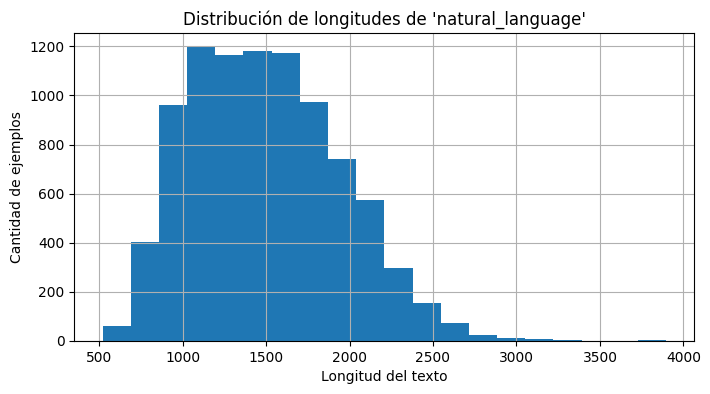

In [7]:
# Obtener longitudes de texto
longitudes = [
    len(item["natural_language"])
    for item in clean_data
    if item.get("natural_language") is not None
]  #Algunos registros tenían este campo en None
plt.figure(figsize=(8, 4))
plt.hist(longitudes, bins=20)  # puedes ajustar el número de bins
plt.title("Distribución de longitudes de 'natural_language'")
plt.xlabel("Longitud del texto")
plt.ylabel("Cantidad de ejemplos")
plt.grid(True)
plt.show()

***
# 3. Desarrollo del modelo

## 3.1 Carga y tokenización 

...

In [8]:
print("Cargando tokenizer y modelo (esto puede tardar)...")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",      # NF4 = mejor precisión
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto",
)

# preparar para k-bit training, Necesario SOLO porque usamos 4-bit:
model = prepare_model_for_kbit_training(model) 

# Desactivar cache y habilitar checkpointing seguro. El KV-cache está pensado para inferencia, no para backprop.
model.config.use_cache = False
try:
    model.gradient_checkpointing_enable(gradient_checkpointing_kwargs={"use_reentrant": False})
except TypeError:
    model.gradient_checkpointing_enable()
torch.utils.checkpoint.use_reentrant = False

# Configurar LoRA
lora_config = LoraConfig(
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    lora_dropout=LORA_DROPOUT,
    target_modules=TARGET_MODULES,
    bias=LORA_BIAS,
    task_type=LORA_TASK_TYPE
)

model_lora = get_peft_model(model, lora_config) # esto es solo para guardar en model_lora
model = model_lora
model.print_trainable_parameters()

Cargando tokenizer y modelo (esto puede tardar)...
trainable params: 4,128,768 || all params: 600,178,688 || trainable%: 0.6879


## 3.2 Revisión de los datos cargados 

In [9]:
lengths_tokens = []
for ex in clean_data:
    txt = custom_sharfun.build_training_example(ex)
    enc = tokenizer(txt, truncation=False, padding=False)
    lengths_tokens.append(len(enc["input_ids"]))

np.percentile(lengths_tokens, [90, 95, 99])

array([1059.  , 1131.  , 1244.03])

In [10]:
stats_val = custom_sharfun.medir_longitudes_tokens(val_list, tokenizer, max_ejemplos=None)
stats_val

{'prompt_mean': 648.8933333333333,
 'prompt_p95': 861.0,
 'prompt_p99': 936.01,
 'json_mean': 206.42222222222222,
 'json_p95': 312.04999999999995,
 'json_p99': 336.02,
 'full_mean': 855.3155555555555,
 'full_p95': 1133.1499999999999,
 'full_p99': 1236.06,
 'full_max': 1449}

## 3.3 Dataloader del corpus 

...

In [11]:
# Tokenizar datos de entrenamiento y validación
train_tokens = [custom_sharfun.tokenize_example_textpair(custom_sharfun.build_training_example(x), MAX_LENGTH, tokenizer, padding = False) for x in train_list]
val_tokens = [custom_sharfun.tokenize_example_textpair(custom_sharfun.build_training_example(x), MAX_LENGTH, tokenizer, padding= False) for x in val_list]

# Simple Dataset + collate_fn (dinámico)
class SimpleTorchDataset(TorchDataset):
    def __init__(self, tokens_list):
        self.data = tokens_list
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return {k: v for k, v in self.data[idx].items()}
    
train_dataset = SimpleTorchDataset(train_tokens)
val_dataset = SimpleTorchDataset(val_tokens)

def collate_fn(batch):
    input_ids = [b['input_ids'] for b in batch]
    attention_mask = [b['attention_mask'] for b in batch]
    labels = [b['labels'] for b in batch]

    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask = pad_sequence(attention_mask, batch_first=True, padding_value=0)
    labels = pad_sequence(labels, batch_first=True, padding_value=-100)

    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'labels': labels
    }

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

## 3.4 Validación de parámetros de entrenamiento

...

In [12]:
# Optimizer + Scheduler
total_steps_per_epoch  = math.ceil(len(train_loader) / GRAD_ACCUM_STEPS)
total_training_steps = EPOCHS * total_steps_per_epoch
num_warmup_steps = int(total_training_steps * WARMUP_RATIO) # warmup calculado desde warmup_ratio

print(f"Total training steps: {total_training_steps}, Warmup steps: {num_warmup_steps}")

# Optimizador
trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = AdamW(trainable_params, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, betas=BETAS, eps=EPS)

# SCHEDULER CON WARMUP
scheduler = get_scheduler(name=SCHEDULER_TYPE, 
                          optimizer=optimizer, 
                          num_warmup_steps=num_warmup_steps, 
                          num_training_steps=total_training_steps)

Total training steps: 3375, Warmup steps: 101


***
# 4. Etapa Entrenamiento

...

In [ ]:
time_start = time.time()

# Entrenamiento manual con AMP (torch.amp) y tqdm
scaler = torch.amp.GradScaler(device='cuda') if DEVICE.startswith('cuda') else torch.amp.GradScaler()
model.to(DEVICE)
model.train()

global_step = 0
optimizer.zero_grad()
for epoch in range(EPOCHS):
    running_loss = 0.0
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{EPOCHS}")
    optimizer.zero_grad()
    for step, batch in pbar:
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        with torch.amp.autocast(device_type='cuda' if DEVICE.startswith('cuda') else 'cpu'):
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss / GRAD_ACCUM_STEPS

        scaler.scale(loss).backward()
        running_loss += loss.item() * GRAD_ACCUM_STEPS

        # UPDATE BLOCK: only when accumulation completes
        if (step + 1) % GRAD_ACCUM_STEPS == 0 or (step + 1) == len(train_loader):
            scaler.unscale_(optimizer)  # 1) Unscale gradients (necessary for clipping)
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM) # 2) Clip gradients
            scaler.step(optimizer) # 3) Optimizer step (scaled)
            scheduler.step() # 4) Scheduler step → usa warmup aquí
            optimizer.zero_grad() # 5) Clear gradients
            scaler.update()  # 6) Scaler update
            global_step += 1

            avg_loss = running_loss / (step + 1)
            pbar.set_postfix({'loss': f"{avg_loss:.4f}", 'lr': scheduler.get_last_lr()[0]})

    print(f"Epoch {epoch+1} finished — avg loss: {running_loss / len(train_loader):.4f}")

end_time = time.time()
print(custom_sharfun.print_time_execution("Entrenamiento completo", time_start, end_time))

Epoch 1/5:   0%|          | 0/4049 [00:00<?, ?it/s]

Epoch 1 finished — avg loss: 1.2017


Epoch 2/5:   0%|          | 0/4049 [00:00<?, ?it/s]

Epoch 2 finished — avg loss: 0.9813


Epoch 3/5:   0%|          | 0/4049 [00:00<?, ?it/s]

Epoch 3 finished — avg loss: 0.9404


Epoch 4/5:   0%|          | 0/4049 [00:00<?, ?it/s]

Epoch 4 finished — avg loss: 0.9168


Epoch 5/5:   0%|          | 0/4049 [00:00<?, ?it/s]

# Guardar modelo entrenado

### 1. En archivos .json

In [ ]:
# Guardar modelo para validar en datos test y pesos en weights.pt
OUTPUT_DIR_MODEL = os.path.join(OUTPUT_DIR, "modfinal")
os.makedirs(OUTPUT_DIR_MODEL, exist_ok=True)

# 1) Guardado en formato Hugging Face (recomendado para cargar con from_pretrained)
model.save_pretrained(OUTPUT_DIR_MODEL)
tokenizer.save_pretrained(OUTPUT_DIR_MODEL)
print("Modelo y tokenizer guardados en", OUTPUT_DIR_MODEL)

# 2) Guardar también los pesos en formato PyTorch clásico: weights.pt
WEIGHTS_PATH = os.path.join(OUTPUT_DIR, "weights_v1.pt")

# Opcional: mover a CPU antes de guardar para evitar referencias al dispositivo
model_cpu = model.to("cpu")
torch.save(model_cpu.state_dict(), WEIGHTS_PATH)
print("Pesos del modelo guardados en", WEIGHTS_PATH)


### 2. Archivo `weights.pt`

In [ ]:
OUTPUT_DIR_MODEL = os.path.join(OUTPUT_DIR, "modfinal_full")
os.makedirs(OUTPUT_DIR_MODEL, exist_ok=True)

ckpt_path = os.path.join(OUTPUT_DIR_MODEL, "weights.pt")
torch.save(
{
    "model_id": MODEL_NAME,
    "model_base": model.base_model.model.state_dict(),
    "peft": model_lora.state_dict(), # solo adaptadores LoRA
    "tokenizer": tokenizer.name_or_path,
    "optimizer": optimizer.state_dict(),
    "scheduler": scheduler.state_dict(),
    "bnb_config": bnb_config.to_dict(),
    "config": {
        "seed": GLB_SEED,
        "max_length": MAX_LENGTH,
        "gen_max_new_tokens": GEN_MAX_NEW_TOKENS,
        "batch_size": BATCH_SIZE,
        "grad_accum_steps": GRAD_ACCUM_STEPS,
        "epochs": EPOCHS,
        "warmup_ratio": WARMUP_RATIO,
        "lr": LEARNING_RATE,
        "weight_decay": WEIGHT_DECAY,
        "betas":BETAS,
        "epsilon": EPS,
        "scheduler_type": SCHEDULER_TYPE,
        "clip_norm": CLIP_NORM,
        "lora_r":LORA_R,
        "lora_alpha":LORA_ALPHA,
        "lora_drop":LORA_DROPOUT,
        "lora_target_mods":TARGET_MODULES,
        "lora_bias": LORA_BIAS,
        "lora_task_type": LORA_TASK_TYPE
    }
}, ckpt_path)
print(f"Checkpoint guardado en: {ckpt_path}")

***
# 5.  Cargue de los datos de validación

Se guardan los datos en otro lugar, dado que en este Notebook no es viable ejecutar puesto que tiene memoria RAM ocupada.  
Se recomienda usar el notebook `validation.ipynb` para observar el score entre el JSON esperado y el JSON predicho.

In [ ]:
OUTPUT_DIR_VALDATA = os.path.join(OUTPUT_DIR, "datavalidation")
os.makedirs(OUTPUT_DIR_VALDATA, exist_ok=True)

val_list.save_to_disk(OUTPUT_DIR_VALDATA)

# Celda para estilo de los markdowns (ignorar)

In [ ]:
%%html
<!-- Fuentes recomendadas para estilo matemático -->
<link href="https://fonts.googleapis.com/css2?family=STIX+Two+Text:ital,wght@0,400;0,700;1,400;1,700&display=swap" rel="stylesheet">
<link href="https://fonts.googleapis.com/css2?family=STIX+Two+Math:ital,wght@0,400;0,700;1,400;1,700&display=swap" rel="stylesheet">
<link href="https://fonts.googleapis.com/css2?family=Inconsolata:wght@400;700&display=swap" rel="stylesheet">

<style>
  /* --- Markdown clásico (Notebook) --- */
  div.text_cell_render.rendered_html p,
  div.text_cell_render.rendered_html h1,
  div.text_cell_render.rendered_html h2,
  div.text_cell_render.rendered_html h3,
  div.text_cell_render.rendered_html li {
    font-family: 'STIX Two Text', serif !important;
  }

  /* MathJax (fórmulas) */
  .MathJax, .MathJax_Display {
    font-family: 'STIX Two Math', serif !important;
  }

  /* Código */
  div.text_cell_render.rendered_html code,
  div.text_cell_render.rendered_html pre {
    font-family: 'Inconsolata', monospace !important;
  }

  /* --- JupyterLab --- */
  .jp-Notebook .jp-RenderedHTMLCommon p,
  .jp-Notebook .jp-RenderedHTMLCommon h1,
  .jp-Notebook .jp-RenderedHTMLCommon h2,
  .jp-Notebook .jp-RenderedHTMLCommon h3,
  .jp-Notebook .jp-RenderedHTMLCommon li {
    font-family: 'STIX Two Text', serif !important;
  }
  .jp-Notebook .jp-RenderedHTMLCommon code,
  .jp-Notebook .jp-RenderedHTMLCommon pre {
    font-family: 'Inconsolata', monospace !important;
  }
  .jp-Notebook .MathJax,
  .jp-Notebook .MathJax_Display {
    font-family: 'STIX Two Math', serif !important;
  }
</style>